In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time, random
import pickle

In [2]:
class Parameter:
    #mini-batch Gradient Descent parameters

    def __init__(self, n_batch, eta, n_epochs):
        self.n_batch = n_batch
        self.eta = eta
        self.n_epochs = n_epochs

# Exercise 1:
### Read in the data and initialize the parameters of the network

In [3]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def loadBatch(filename):
    cifar = unpickle(filename)

    X = cifar[b'data'].T  # numpy array of size dxN     
    y = np.array(cifar[b'labels'])  # vector of lables of size 1xN
    Y = np.zeros((10,X.shape[1]))  # matrix of KxN
    Y[y,np.arange(len(y))] = 1

    return X,Y,y

def initializeParams(n_nodes,n_class,seed=None):
    W = []
    b = []
    n_layer = len(n_nodes)
    n_in = n_nodes[0]
    for i in range(n_layer):
        if i<n_layer-1:
            n_out = n_nodes[i+1]           
        else: 
            n_out = n_class  # last output        
        W.append(np.random.randn(n_out,n_in)/np.sqrt(n_in))
        b.append(np.zeros((n_out,1)))
        n_in = n_out
        
    return W,b

# Exercise 2:
### Compute the gradients for the network parameters

In [4]:
def computeScore(X,W,b):
    s = np.dot(W,X) + b
    return s

def ReLu(s):
    return np.maximum(0,s)

def SoftMax(s):
    p = np.exp(s)/np.expand_dims(np.exp(s).sum(axis=0),axis=0)  # matrix of size KxN
    return p

def evaluateClassifier(X,W,b):
    # W : 3D matrix of all weights matrix
    # b : 2D matrix of all threshold
    n_layer = len(W)
    h = X
    H = []
    for i in range(n_layer-1):
        s = computeScore(h,W[i],b[i])
        h = ReLu(s)
        H.append(h)
    s = computeScore(h,W[-1],b[-1])
    P = SoftMax(s)
    return H,P

def computeAccuracy(X,y,W,b):
    H,P = evaluateClassifier(X,W,b)
    y_pred = np.argmax(P, axis=0)
    acc = np.sum(y==y_pred)/(len(y)+0.0)
    return acc

def computeCost(X,Y,W,b,lamb):
    H,P = evaluateClassifier(X,W,b)
    loss = np.sum(-np.log(np.diag(np.dot(Y.T,P))))/(X.shape[1]+0.0)
    cost = loss + lamb*sum([np.einsum('ij,ij', wi, wi) for wi in W])
    return loss, cost
    
def computeGradients(X,Y,W,b,lamb):
    grad_W = []
    grad_b = []
    N = X.shape[1]
    H,P = evaluateClassifier(X,W,b)
    g = P-Y
    for i in range(len(W)-1):
        h = H[-1-i]
        grad_b.append(np.expand_dims(g.sum(axis=1),axis=1)/(N+0.0))
        grad_W.append(np.dot(g,h.T)/(N+0.0) + 2*lamb*W[-1-i])
             
        Ind = np.zeros(h.shape)
        Ind[h>0] = 1
        g = np.dot(W[-1-i].T,g)*Ind
    
    grad_b.append(np.expand_dims(g.sum(axis=1),axis=1)/(N+0.0))
    grad_W.append(np.dot(g,X.T)/(N+0.0) + 2*lamb*W[0])
    
    return list(reversed(grad_W)), list(reversed(grad_b))

def computeGradsNumSlow(X, Y, W, b, lamb, h):
    grad_W = []
    grad_b = []
    for k in range(len(W)):
        n_out,n_in = W[k].shape

        gw = np.zeros(W[k].shape)
        gb = np.zeros((n_out, 1))

        for i in range(len(b[k])):
            b[k][i] -= h
            l1,c1 = computeCost(X, Y, W, b, lamb)
            b[k][i] += 2*h
            l2,c2 = computeCost(X, Y, W, b, lamb)
            b[k][i] -= h
            gb[i] = (c2-c1)/(2*h)

        for i in range(n_out):
            for j in range(n_in):
                W[k][i,j] -= h
                l1,c1 = computeCost(X, Y, W, b, lamb)
                W[k][i,j] += 2*h
                l2,c2 = computeCost(X, Y, W, b, lamb)
                W[k][i,j] -= h
                gw[i,j] = (c2-c1)/(2*h)
        grad_W.append(gw)
        grad_b.append(gb)
    return grad_W, grad_b

def generateBatches(X,Y,n_batch):
    d,N = X.shape
    K = Y.shape[0]
    XBatch = np.zeros((d,n_batch,int(N/n_batch)))
    YBatch = np.zeros((K,n_batch,int(N/n_batch)))
    
    for i in range(int(N/n_batch)):
        i_start = i*n_batch
        i_end = (i+1)*n_batch
        XBatch[:,:,i] = X[:,i_start:i_end]
        YBatch[:,:,i] = Y[:,i_start:i_end]
    return XBatch, YBatch

def plotResults(x,y,name='loss',par='0'):
    fig = plt.figure()
    plt.plot(x,y[0],label='training '+name)
    plt.plot(x,y[1],label='validation '+name)
    plt.legend(loc=0)
    plt.xlabel('n_updates')
    plt.ylabel(name)
    fig.savefig('Figures/'+name+'_params'+par+'.pdf')
    plt.show()

# Plot W
def plotW(W,class_name,arg_par='0'):
    fig=plt.figure(figsize=(20,2))
    for i in range(10):
        im = W[i,:].reshape(3,32,32)
        img = np.transpose((im-np.min(im))/(np.max(im)-np.min(im)),(1,2,0))
        plt.subplot(1, 10, i+1)                 
        plt.title(class_name[i])
        plt.imshow(img)
        plt.axis('off')
                       
    plt.savefig('Figures/imW_params'+arg_par+'.pdf')
    plt.show()

# Check gradient computation
def checkGrads(X, Y, W, b, lamb, h=1e-6):
    eps = 1e-30
    error = 1e-6
    
    gW1,gb1 = computeGradsNumSlow(X,Y,W,b,lamb, h)
    gW2,gb2 = computeGradients(X,Y,W,b,lamb)
    
    total_error_w = 0
    total_error_b = 0
    max_w = np.zeros(len(W))
    max_b = np.zeros(len(W))
    
    for i in range(len(W)):
        error_w = np.abs(gW1[i]-gW2[i])/np.maximum(eps,np.abs(gW1[i])+np.abs(gW2[i]))
        error_b = np.abs(gb1[i]-gb2[i])/np.maximum(eps,np.abs(gb1[i])+np.abs(gb2[i]))
        total_error_w += np.sum(error_w>error)
        total_error_b += np.sum(error_b>error)
        max_w[i] = np.max(error_w)
        max_b[i] = np.max(error_b)
    print('The number of errors (relative error > 1e-6) of W:', total_error_w)
    print('The maximum of relative error of W:', np.max(max_w))
    print('The number of errors (relative error > 1e-6) of b:', total_error_b)
    print('The maximum of relative error of b:', np.max(max_b))

In [5]:
def plotCost(X,Y,y,W_train,b_train,lamb,step,name_par='0'):
    update = np.append(np.arange(0,len(W_train)-1,step),len(W_train)-1)
    n_update = len(update)
    loss_train = np.zeros(n_update)   
    loss_val = np.zeros(n_update)
    cost_train = np.zeros(n_update)   
    cost_val = np.zeros(n_update)
    error_train = np.zeros(n_update)   
    error_val = np.zeros(n_update)
    for ind,i in enumerate(update):
        loss_train[ind],cost_train[ind] = computeCost(X[0],Y[0],W_train[i],b_train[i],lamb)        
        loss_val[ind],cost_val[ind] = computeCost(X[1],Y[1],W_train[i],b_train[i],lamb)   
        
        error_train[ind] = computeAccuracy(X[0],y[0],W_train[i],b_train[i]) 
        error_val[ind] = computeAccuracy(X[1],y[1],W_train[i],b_train[i]) 
    plotResults(update,[loss_train, loss_val],'loss',name_par)
    plotResults(update,[cost_train, cost_val],'cost',name_par)
    plotResults(update,[error_train, error_val],'accuracy',name_par)

In [18]:
def normalize(trainX, valX, testX):
    mean_train = np.mean(trainX,axis=1).reshape(-1,1)
    std_train = np.std(trainX,axis=1).reshape(-1,1)
    trainX = (trainX-mean_train)/std_train
    valX = (valX-mean_train)/std_train
    testX = (testX-mean_train)/std_train
    return trainX, valX, testX

In [34]:
# Load data
path = 'Datasets-py/'
XBatch_1,YBatch_1,yBatch_1 = loadBatch(path+'data_batch_1')  # Training set
XBatch_2,YBatch_2,yBatch_2 = loadBatch(path+'data_batch_2')  # Validation set
XBatch_test,YBatch_test,yBatch_test = loadBatch(path+'test_batch')    # Test set

XTr,XVa, XTe = normalize(XBatch_1, XBatch_2, XBatch_test)
YTr = YBatch_1
YVa = YBatch_2
YTe = YBatch_test
yTr = yBatch_1
yVa = yBatch_2
yTe = yBatch_test


names = unpickle(path+'batches.meta')[b'label_names']  # list if size (10,1)

K = len(names)
class_name = []
for i in range(K):
    class_name.append(names[i].decode("utf-8"))

In [21]:
X = XTr[:20,:5]
Y = YTr[:,:5]
n_nodes = np.array([X.shape[0]])

W,b = initializeParams(n_nodes,10)
checkGrads(X, Y, W, b, 0.01, 1e-5)

The number of errors (relative error > 1e-6) of W: 0
The maximum of relative error of W: 1.1953941636224952e-08
The number of errors (relative error > 1e-6) of b: 0
The maximum of relative error of b: 1.9811087323985876e-10


In [22]:
def miniBatchGD(X,Y,y,GDparams,W,b,lamb):
    X_train = X[0]
    Y_train = Y[0]
    y_train = y[0]
    X_val = X[1]
    Y_val = Y[1]
    y_val = y[1]
    
    d,N = X_train.shape
    numBatches = int(np.floor(N/GDparams.n_batch))    
    if type(GDparams.eta) is np.ndarray: 
        eta = GDparams.eta        
    else:
        eta = np.zeros(GDparams.n_epochs*numBatches)
        eta[:] = GDparams.eta
        
    W_train = []
    b_train = []
    W_star = W
    b_star = b
    W_train.append(W_star[:])
    b_train.append(b_star[:])
    
    XBatch,YBatch = generateBatches(X_train,Y_train,GDparams.n_batch)
    t = 0
    for i in range(GDparams.n_epochs):
        for j in range(numBatches):
            xTr = XBatch[:,:,j]
            yTr = YBatch[:,:,j]            
            grad_w,grad_b = computeGradients(xTr,yTr,W_star,b_star,lamb)
            # update the weights and the thresholds               
            for k in range(len(W)):
                W_star[k] = W_star[k] - eta[t]*grad_w[k]
                b_star[k] = b_star[k] - eta[t]*grad_b[k]
            t += 1  
            W_train.append(W_star[:])
            b_train.append(b_star[:])
    
    return W_train,b_train

In [23]:
X = [XTr[:,:100], XVa[:,:100]]
Y = [YTr[:,:100], YVa[:,:100]]
y = [yTr[:100], yVa[:100]]

n_nodes = np.array([X[0].shape[0], 50])

In [24]:
# 
W,b = initializeParams(n_nodes,10)
lamb = 0
GDparams = Parameter(100,0.01,200)

W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

The accuracy on test set:  19.08 %


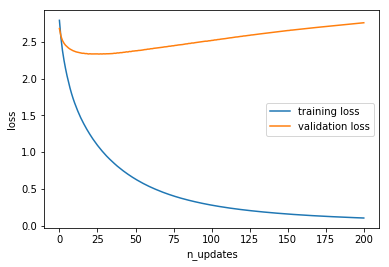

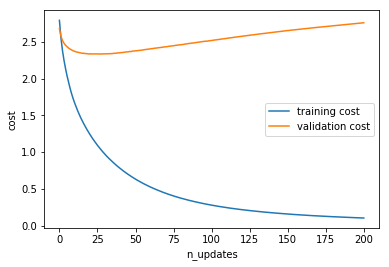

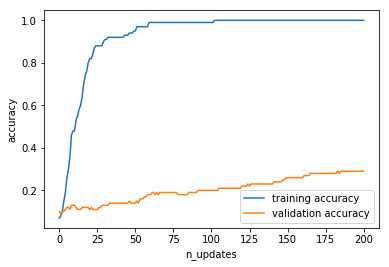

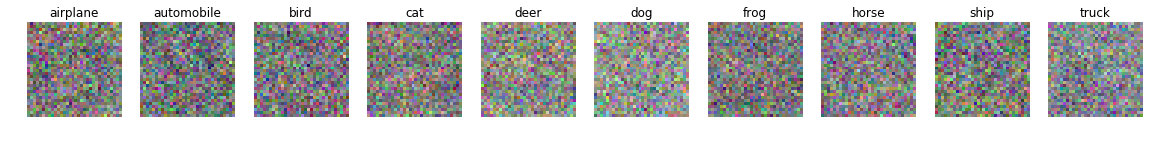

In [25]:
name_par = 'Ex1'
step = 1

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

# Exercise 3:
### Train the network with cyclical learning rate

In [26]:
def cylicalEta(eta_min,eta_max,stepsize,n_cycle):
    iterations = np.arange(2*n_cycle*stepsize)
    cycle = np.floor(1 + iterations/(2*stepsize))
    x = np.abs(iterations/stepsize - 2*cycle + 1)
    eta = eta_min + (eta_max - eta_min)*np.maximum(0.0, (1-x))
    return eta

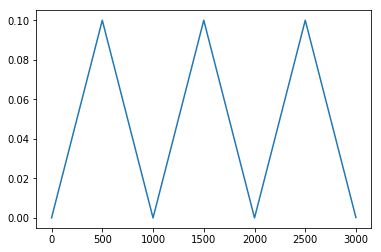

In [27]:
eta_min = 1e-5
eta_max = 1e-1
n_s = 500
n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
plt.plot(range(len(eta)),eta)
plt.show()

In [35]:
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

n_nodes = np.array([X[0].shape[0], 50])

In [36]:
W,b = initializeParams(n_nodes,K)

eta_min = 1e-5
eta_max = 1e-1
n_s = 500
n_cycle = 1
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
n_batch = 100
lamb = 0.01

GDparams = Parameter(100,eta,10)

start = time.time()
W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  13.905077934265137
The accuracy on test set:  46.42 %


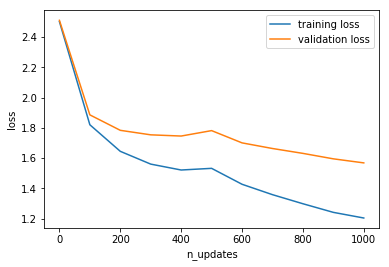

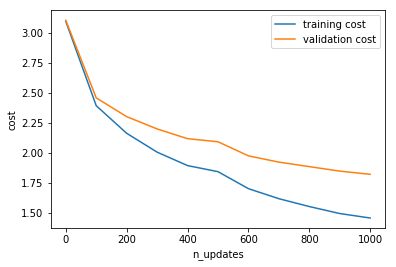

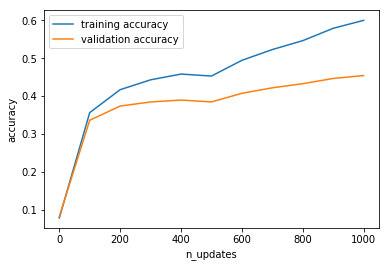

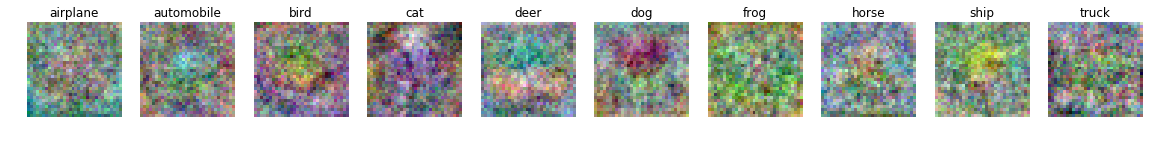

In [37]:
name_par = 'Ex3_0'
step = 100

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

# Exercise 4:
### Train your network for real

In [38]:
W,b = initializeParams(n_nodes,K)

eta_min = 1e-5
eta_max = 1e-1
n_s = 800
n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
n_batch = 100
lamb = 0.01
n_epochs = int(2*n_cycle*n_s/X[0].shape[1]*n_batch)

GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  61.0020489692688
The accuracy on test set:  47.160000000000004 %


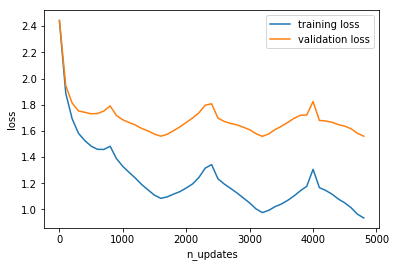

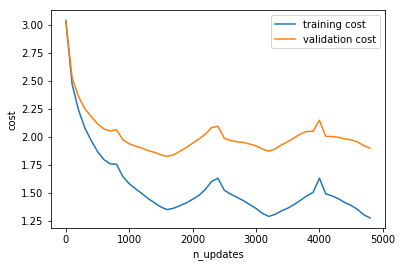

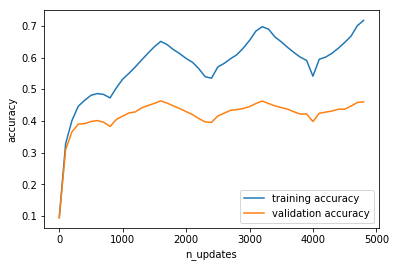

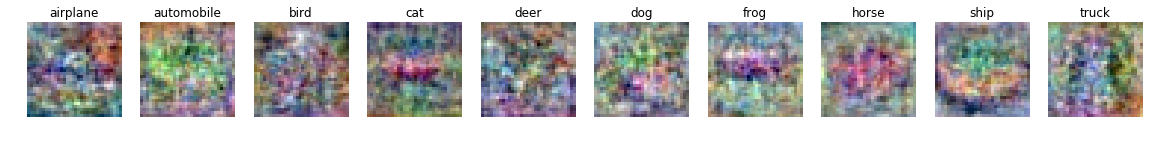

In [39]:
name_par = 'Ex4_0'
step = 100

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

### Coarse-to-fine random search

In [40]:
def randomSearch(l_range,X,Y,y,n_cycle=2,n_lamb=10,name_par='0'):
    d,n = X[0].shape
    
    n_batch = 100
    eta_min = 1e-5
    eta_max = 1e-1
    n_s = int(2*np.floor(n/n_batch))
    eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
    n_epochs = int(2*n_cycle*n_s/n*n_batch)
    n_node = 50

    GDparams = Parameter(n_batch,eta,n_epochs)
    
    acc_val = np.zeros(n_lamb)
    lamb = np.zeros(n_lamb)
    W_best = []
    b_best = []
    n_nodes = np.array([d, n_node])
    n_layer = len(n_nodes)
    
    parameters = dict(n_batch=n_batch,n_epochs=n_epochs,eta_min=eta_min,eta_max=eta_max,step=n_s,
                      n_cycle=n_cycle,n_nodes=n_nodes,n_layer=n_layer)
    for i in range(n_lamb):
        W,b = initializeParams(n_nodes,10)
        # set random lambda
        l = l_range[0] + (l_range[1]-l_range[0])*np.random.rand(1)
        lamb[i] = 10**l
        
        W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb[i])
        
        acc_val[i] = computeAccuracy(X[1],y[1],W_train[-1],b_train[-1])
        W_best.append(W_train[-1])
        b_best.append(b_train[-1])
    parameters['lambda'] = lamb
    result = dict(parameters=parameters, accuracy=acc_val, weight=W_best, threshold=b_best)
    with open('search_'+name_par+'.txt', 'wb') as fp:
        pickle.dump(result, fp)

In [41]:
# Use all data to train
path = 'Datasets-py/'
XTr_1,YTr_1,yTr_1 = loadBatch(path+'data_batch_1')  # Training set
XTr_2,YTr_2,yTr_2 = loadBatch(path+'data_batch_2') 
XTr_3,YTr_3,yTr_3 = loadBatch(path+'data_batch_3')
XTr_4,YTr_4,yTr_4 = loadBatch(path+'data_batch_4')
XTr_5,YTr_5,yTr_5 = loadBatch(path+'data_batch_5')
XTrain = np.concatenate((XTr_1, XTr_2, XTr_3, XTr_4, XTr_5), axis=1)
YTr = np.concatenate((YTr_1, YTr_2, YTr_3, YTr_4, YTr_5), axis=1)
yTr = np.concatenate((yTr_1, yTr_2, yTr_3, yTr_4, yTr_5))

XValid = XTrain[:,-5000:] 
YVa = YTr[:,-5000:]
yVa = yTr[-5000:]
XTrain = XTrain[:,:-5000] 
YTr = YTr[:,:-5000]
yTr = yTr[:-5000]

XTest,YTe,yTe = loadBatch(path+'test_batch')    # Test set

XTr, XVa, XTe = normalize(XTrain, XValid, XTest)

names = unpickle(path+'batches.meta')[b'label_names']  # list if size (10,1)

K = len(names)
class_name = []
for i in range(K):
    class_name.append(names[i].decode("utf-8"))

In [42]:
X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

In [43]:
l_range = np.array([-5, -1])
start = time.time()
randomSearch(l_range,X,Y,y,n_cycle=2,n_lamb=20,name_par='lamb_1')
print('Execution time: ',time.time()-start)

Execution time:  1385.9739000797272


In [44]:
res = unpickle('search_lamb_1.txt')
print(res['accuracy'])
print(res['parameters']['lambda'])

[0.5218 0.5228 0.3978 0.5182 0.519  0.5178 0.5226 0.4922 0.5262 0.4484
 0.5286 0.4904 0.5138 0.523  0.5246 0.5224 0.5182 0.5232 0.5276 0.4002]
[3.55240022e-03 3.47669570e-05 8.24005374e-02 8.29727516e-05
 1.49507083e-04 5.57422931e-04 3.46017382e-05 1.80005781e-02
 1.07751261e-03 4.21716810e-02 7.55779755e-04 1.88049382e-02
 1.33567674e-05 1.72112666e-03 1.65406959e-03 2.56584908e-03
 4.54505867e-04 1.64955453e-04 1.65541537e-03 7.93022912e-02]


In [48]:
la = res['parameters']['lambda']
ac = res['accuracy']
print(la[ac>0.51])
print(la[ac<=0.51])
print(la[ac>0.52])

[3.55240022e-03 3.47669570e-05 8.29727516e-05 1.49507083e-04
 5.57422931e-04 3.46017382e-05 1.07751261e-03 7.55779755e-04
 1.33567674e-05 1.72112666e-03 1.65406959e-03 2.56584908e-03
 4.54505867e-04 1.64955453e-04 1.65541537e-03]
[0.08240054 0.01800058 0.04217168 0.01880494 0.07930229]
[3.55240022e-03 3.47669570e-05 3.46017382e-05 1.07751261e-03
 7.55779755e-04 1.72112666e-03 1.65406959e-03 2.56584908e-03
 1.64955453e-04 1.65541537e-03]


In [46]:
print('The 3 best perfomances are: ',ac[ac.argsort()[-3:][::-1]])
print('The corresponding lambdas to the best ones: ', res['parameters']['lambda'][ac.argsort()[-3:][::-1]])

The 3 best perfomances are:  [0.5286 0.5276 0.5262]
The corresponding lambdas to the best ones:  [0.00075578 0.00165542 0.00107751]


In [49]:
print('The best test accuracy is: ',ac.max())
print('The corresponding parameters to the best accuracy: ',res['parameters'], res['parameters']['lambda'][np.argmax(ac)])
print(res['parameters']['eta_min'])

The best test accuracy is:  0.5286
The corresponding parameters to the best accuracy:  {'n_batch': 100, 'n_epochs': 8, 'eta_min': 1e-05, 'eta_max': 0.1, 'step': 900, 'n_cycle': 2, 'n_nodes': array([3072,   50]), 'n_layer': 2, 'lambda': array([3.55240022e-03, 3.47669570e-05, 8.24005374e-02, 8.29727516e-05,
       1.49507083e-04, 5.57422931e-04, 3.46017382e-05, 1.80005781e-02,
       1.07751261e-03, 4.21716810e-02, 7.55779755e-04, 1.88049382e-02,
       1.33567674e-05, 1.72112666e-03, 1.65406959e-03, 2.56584908e-03,
       4.54505867e-04, 1.64955453e-04, 1.65541537e-03, 7.93022912e-02])} 0.0007557797548402008
1e-05


In [50]:
# Fine search: base on the result of the previous task to narrow lambda range. Train more circle
l_range = np.array([-5, -2])
start = time.time()
randomSearch(l_range,X,Y,y,n_cycle=3,n_lamb=20,name_par='lamb_2')
print('Execution time: ',time.time()-start)

Execution time:  2067.5537679195404


In [51]:
res = unpickle('search_lamb_2.txt')
print(res['accuracy'])
print(res['parameters']['lambda'])

[0.5128 0.5252 0.5178 0.5152 0.5216 0.519  0.5246 0.513  0.5246 0.5198
 0.5178 0.5182 0.5204 0.5168 0.5182 0.5236 0.5254 0.524  0.5178 0.5316]
[9.09732513e-04 3.60994706e-03 4.31586708e-05 1.75012206e-04
 3.76558170e-04 1.62505944e-04 1.50610582e-05 4.64997128e-05
 1.00380855e-05 9.58060373e-05 2.05738032e-04 1.93332162e-03
 5.51819024e-03 3.08106793e-05 2.59452361e-04 2.83806147e-04
 1.99863233e-03 3.00319698e-05 3.30180531e-04 4.50930455e-03]


In [52]:
la = res['parameters']['lambda']
ac = res['accuracy']
print(la[ac>0.522])
print(la[ac<=0.522])

[3.60994706e-03 1.50610582e-05 1.00380855e-05 2.83806147e-04
 1.99863233e-03 3.00319698e-05 4.50930455e-03]
[9.09732513e-04 4.31586708e-05 1.75012206e-04 3.76558170e-04
 1.62505944e-04 4.64997128e-05 9.58060373e-05 2.05738032e-04
 1.93332162e-03 5.51819024e-03 3.08106793e-05 2.59452361e-04
 3.30180531e-04]


In [53]:
print('The 3 best perfomances are: ',ac[ac.argsort()[-3:][::-1]])
print('The corresponding lambdas to the best ones: ', res['parameters']['lambda'][ac.argsort()[-3:][::-1]])

The 3 best perfomances are:  [0.5316 0.5254 0.5252]
The corresponding lambdas to the best ones:  [0.0045093  0.00199863 0.00360995]


In [54]:
# Fine search: base on the result of the previous task to narrow lambda range. Train more circle
l_range = np.array([-4, -2])
start = time.time()
randomSearch(l_range,X,Y,y,n_cycle=3,n_lamb=20,name_par='lamb_3')
print('Execution time: ',time.time()-start)

Execution time:  1737.0449087619781


In [55]:
res = unpickle('search_lamb_3.txt')
la = res['parameters']['lambda']
ac = res['accuracy']
print(ac)
print(la)

print(la[ac>0.522])
print(la[ac<=0.522])

[0.5214 0.525  0.5202 0.5242 0.5252 0.5208 0.5204 0.5256 0.528  0.5254
 0.522  0.522  0.5208 0.5186 0.5246 0.523  0.518  0.5184 0.5092 0.5228]
[0.00041699 0.00529136 0.00018423 0.00054286 0.00186715 0.00127312
 0.00743681 0.00048179 0.00268647 0.00651218 0.00287009 0.00028908
 0.00085098 0.00033835 0.0008005  0.00091284 0.00059987 0.0007016
 0.00965755 0.00614181]
[0.00529136 0.00054286 0.00186715 0.00048179 0.00268647 0.00651218
 0.0008005  0.00091284 0.00614181]
[0.00041699 0.00018423 0.00127312 0.00743681 0.00287009 0.00028908
 0.00085098 0.00033835 0.00059987 0.0007016  0.00965755]


In [56]:
print('The 3 best perfomances are: ',ac[ac.argsort()[-3:][::-1]])
print('The corresponding lambdas to the best ones: ', res['parameters']['lambda'][ac.argsort()[-3:][::-1]])

The 3 best perfomances are:  [0.528  0.5256 0.5254]
The corresponding lambdas to the best ones:  [0.00268647 0.00048179 0.00651218]


In [57]:
print('The best test accuracy is: ',ac.max())
print('The corresponding parameters to the best accuracy: ',res['parameters'], res['parameters']['lambda'][np.argmax(ac)])
print(res['parameters']['eta_min'])

The best test accuracy is:  0.528
The corresponding parameters to the best accuracy:  {'n_batch': 100, 'n_epochs': 12, 'eta_min': 1e-05, 'eta_max': 0.1, 'step': 900, 'n_cycle': 3, 'n_nodes': array([3072,   50]), 'n_layer': 2, 'lambda': array([0.00041699, 0.00529136, 0.00018423, 0.00054286, 0.00186715,
       0.00127312, 0.00743681, 0.00048179, 0.00268647, 0.00651218,
       0.00287009, 0.00028908, 0.00085098, 0.00033835, 0.0008005 ,
       0.00091284, 0.00059987, 0.0007016 , 0.00965755, 0.00614181])} 0.0026864721834310825
1e-05


In [58]:
XTrain = np.concatenate((XTr_1, XTr_2, XTr_3, XTr_4, XTr_5), axis=1)
YTr = np.concatenate((YTr_1, YTr_2, YTr_3, YTr_4, YTr_5), axis=1)
yTr = np.concatenate((yTr_1, yTr_2, yTr_3, yTr_4, yTr_5))

XValid = XTrain[:,-1000:] 
YVa = YTr[:,-1000:]
yVa = yTr[-1000:]
XTrain = XTrain[:,:-1000] 
YTr = YTr[:,:-1000]
yTr = yTr[:-1000]

XTr, XVa, XTe = normalize(XTrain, XValid, XTest)

X = [XTr, XVa]
Y = [YTr, YVa]
y = [yTr, yVa]

In [62]:
d,n = X[0].shape
n_node = 50
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)
n_batch = 100

eta_min = 1e-5
eta_max = 1e-1
n_s = int(2*np.floor(n/n_batch))
n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
lamb = res['parameters']['lambda'][np.argmax(ac)]
n_epochs = int(2*n_cycle*n_s/X[0].shape[1]*n_batch)

GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  94.06274509429932
The accuracy on test set:  52.01 %


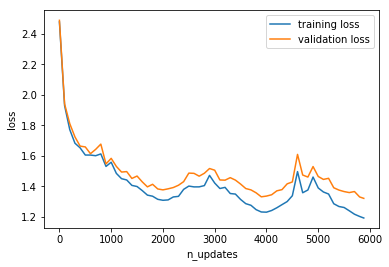

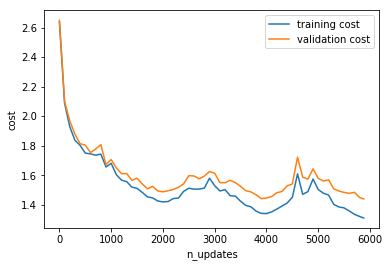

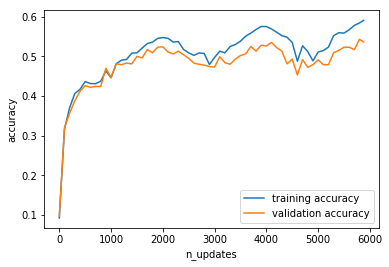

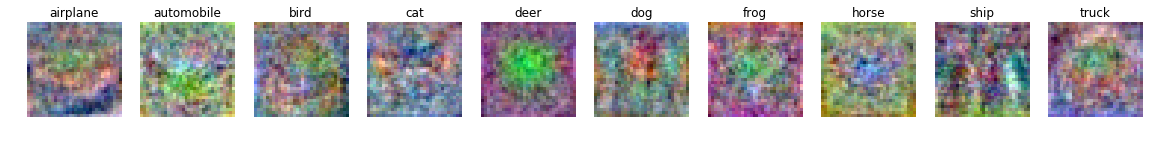

In [63]:
step = 100
name_par = 'best_3cycle'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

# Exercise 5:
## 5.1 Improvement

In [51]:
W,b = initializeParams(n_nodes,K)
n_batch = 100

eta_min = 1e-5
eta_max = 1e-1
n_s = int(2*np.floor(n/n_batch))
n_cycle = 6
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
lamb = res['parameters']['lambda'][np.argmax(ac)]
n_epochs = int(2*n_cycle*n_s/X[0].shape[1]*n_batch)

GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  205.98660492897034
The accuracy on test set:  52.1 %


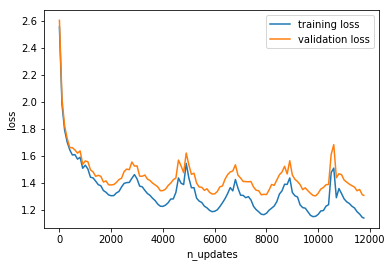

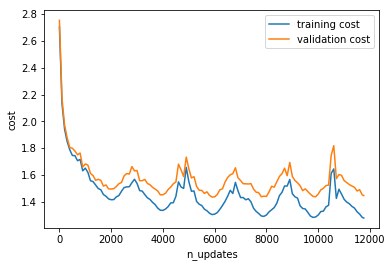

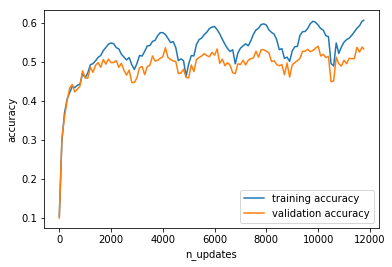

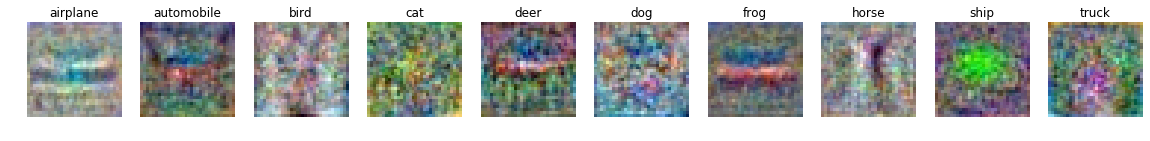

In [52]:
step = 100
name_par = 'best_6cycle'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [53]:
# Improve (b)
d,n = X[0].shape
n_node = 100
n_nodes = np.array([d, n_node])

W,b = initializeParams(n_nodes,K)
n_batch = 100

eta_min = 1e-5
eta_max = 1e-1
n_s = int(2*np.floor(n/n_batch))
n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
lamb = 2*res['parameters']['lambda'][np.argmax(ac)]
n_epochs = int(2*n_cycle*n_s/X[0].shape[1]*n_batch)

GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  126.33261013031006
The accuracy on test set:  53.93 %


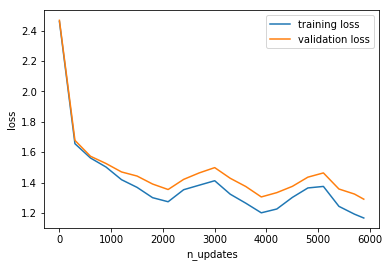

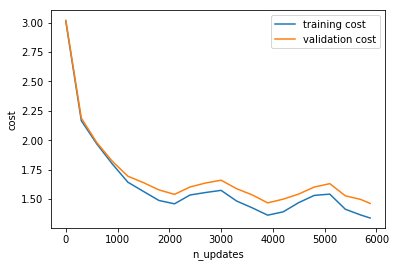

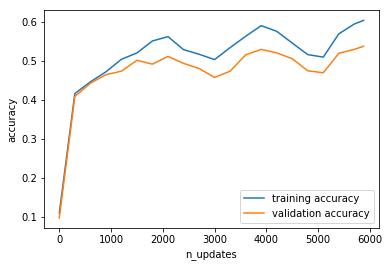

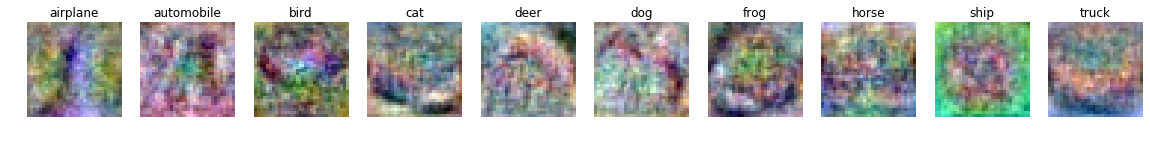

In [54]:
step = 300
name_par = 'impr_100nodes'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

plotW(W_train[-1][0],class_name,name_par)

In [60]:
d,n = X[0].shape
n_node = 50
n_nodes = np.array([d, n_node, n_node, n_node, n_node])

W,b = initializeParams(n_nodes,K)
n_batch = 100

eta_min = 1e-5
eta_max = 1e-1
n_s = int(2*np.floor(n/n_batch))
n_cycle = 3
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
lamb = res['parameters']['lambda'][np.argmax(ac)]
n_epochs = int(2*n_cycle*n_s/X[0].shape[1]*n_batch)

GDparams = Parameter(n_batch,eta,n_epochs)

start = time.time()
W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
print('Execution time: ',time.time()-start)
print('The accuracy on test set: ',computeAccuracy(XTe,yTe,W_train[-1],b_train[-1])*100,'%')

Execution time:  109.12055587768555
The accuracy on test set:  52.65 %


## 5.2 Find the boundary for learning rate

In [116]:
def findEta(X,Y,y,eta_range,nodes,lamb,name='0'):  
    eta_min = eta_range[0]
    eta_max = eta_range[1]
    n_batch = 100
    n_epochs = 8
    n_s = int(X[0].shape[1]/n_batch)*n_epochs
    n_cycle = 0.5
    eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)
    
    W,b = initializeParams(nodes,K)
    GDparams = Parameter(n_batch,eta,n_epochs)
    W_train,b_train = miniBatchGD(X,Y,y,GDparams,W,b,lamb)
    return W_train, b_train

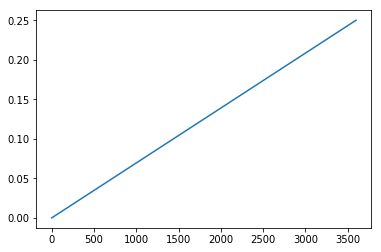

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in maximum
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


In [115]:
d,n = X[0].shape
n_node = 50
n_nodes = np.array([d, n_node])

lamb = 0.0006112139955292869

eta_range = np.array((0,1))
W_train, b_train = findEta(X,Y,y,eta_range,n_nodes,lamb)

In [117]:
eta_min = eta_range[0]
eta_max = eta_range[1]
n_batch = 100
n_epochs = 8
n_s = int(X[0].shape[1]/n_batch)*n_epochs
n_cycle = 0.5
eta = cylicalEta(eta_min,eta_max,n_s,n_cycle)

In [ ]:
step = 100
name_par = 'LRRangTest'

plotCost(X,Y,y,W_train,b_train,lamb,step,name_par)

3 0.0872 0.0001388888888889106


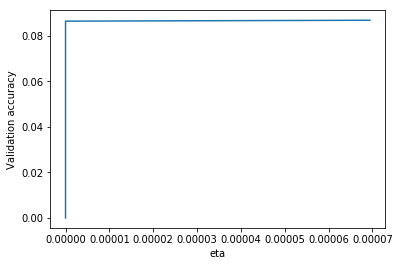

In [146]:
name = '0'

loss_val = np.zeros(len(W_train))
cost_val = np.zeros(len(W_train))
for i in range(1,len(W_train)):
    loss_val[i],cost_val[i] = computeCost(X[1],Y[1],W_train[i],b_train[i],lamb)
    if np.abs(loss_val[i]-loss_val[i-1])>0.1 and i>2:
        print(i, loss_val[i], eta[i-1])
        break
        
fig = plt.figure()
plt.plot(eta[:i-1],loss_val[1:i])
plt.xlabel('eta')
plt.ylabel('Validation loss')
fig.savefig('Figures/etaSearch_loss'+name+'.pdf')

plt.plot(eta[:i-1],loss_val[1:i])
plt.xlabel('eta')
plt.ylabel('Validation cost')
fig.savefig('Figures/etaSearch_cost'+name+'.pdf')
plt.show()

In [86]:
GDparams = Parameter(100,0.01,10)
print(type(GDparams.eta))

SyntaxError: invalid syntax (<ipython-input-86-241bacce8b51>, line 2)

In [ ]:
eta = np.arange(1e-6,2e-2,1e-3)
print(len(eta))
findEta(X,Y,y,eta,n_nodes,lamb,name='002')

20


In [85]:
a = np.random.randn(3,1)
print(len(a))
print(a[len(a)-1])
b = np.random.randn(2,3)
a[b>0] = 0
print(b)
print(a)
print(np.mean(a,axis=1))
print((a-np.mean(a, axis=1).reshape(-1,1))/np.std(a, axis=1).reshape(-1,1))

b = np.array([a,np.random.randn(4,5)])
print(len(b),b[1].shape)

3
[-0.97072167]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 2

In [34]:
x = np.zeros(3)
x[:] = 1
print(cylicalEta(0.01,0.1,50,100).shape)
print(x.shape)
print(np.arange(0,1e-4,1e-5).shape)

(100,)
(3,)
(10,)


In [55]:
A = np.array([np.random.randn(10,20),np.random.rand(5,10)])

In [23]:
print(10**(-2.5))

0.0031622776601683794
